# Импорты

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import lightgbm as lgb 
import optuna
import featuretools as ft
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

# Импорт данных

In [2]:
data = pd.read_csv("train_1.csv")

In [3]:
data = data.sort_values(by='target', ascending=False)

<Axes: xlabel='target', ylabel='count'>

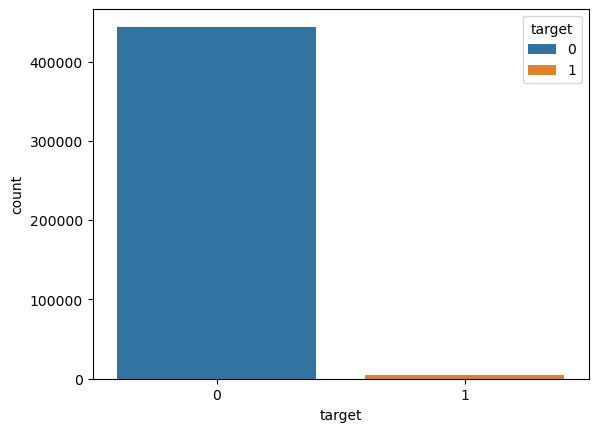

In [4]:
sns.countplot(data=data, x='target', hue='target')

In [ ]:
X = data.drop(columns=['id', 'smpl', 'target']).values
y = data['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Функции для препарейшна и идеи

In [ ]:
#PCA + RFE -> 76% (Следует сначала сгенирировать фичи, а затем отобрать) пробуем и featuretools и tsfresh

In [ ]:
def data_preparation(data):
    X = data.drop(columns=['id', 'smpl', 'target']).values
    y = data['target'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=389)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = model_lgb = lgb.LGBMClassifier(random_state=42)
    
    rfe = RFE(estimator=model, n_features_to_select=25)
    rfe.fit(X_train, y_train)
    selected_feature_indices = rfe.get_support(indices=True)

    X_train_selected = X_train[:, selected_feature_indices]
    X_test_selected = X_test[:, selected_feature_indices]

    return X_train_selected, X_test_selected

def data_preparation(data):
    X = data.drop(columns=['id', 'smpl', 'target']).values
    y = data['target'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=389)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return pca

def pca_vizualization(pca):
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Количество компонент')
    plt.ylabel('Доля объясненной дисперсии')
    plt.title('Доля объясненной дисперсии в зависимости от количества компонент')
    plt.grid(True)
    plt.show()
    
    n_components = (cumulative_explained_variance < 0.95).sum() + 1
    print(f'Количество компонент, сохраняющих 95% информации: {n_components}')

In [ ]:
def data_for_lgb(train_data, test_data):
    train_data = lgb.Dataset(
        X_train_selected,
        y_train,
        free_raw_data=False,
    )
    test_data = lgb.Dataset(
        X_test_selected,
        y_test,
        free_raw_data=False,
    )

# Генерация фичей и идеи

### featuretools

In [ ]:
# es = ft.EntitySet(id='data')
# es = es.add_dataframe(dataframe_name='transactions', dataframe=data, index='id')

# agg_primitives = ["sum", "mean", "median", "std", "max", "min"]
# trans_primitives = ["add_numeric", "multiply_numeric", "divide_numeric", "subtract_numeric"]

# feature_matrix, feature_defs = ft.dfs(
#     entityset=es,
#     target_dataframe_name='transactions',
#     max_depth=2,
#     agg_primitives=agg_primitives,
#     trans_primitives=trans_primitives
# )

# print(feature_matrix.head())

#Способ ничего не дал (

### tsfresh

In [ ]:
# features = extract_features(data, column_id="id", impute_function=impute)
# print(features.head())

#Это вообще не запустилось

### poly features - generation + selection

In [13]:
# # Генерация полиномиальных признаков по частям
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# def generate_poly_features(X, poly, batch_size=1000):
#     num_samples = X.shape[0]
#     poly_features = []
#     for i in tqdm(range(0, num_samples, batch_size)):
#         batch = X[i:i + batch_size]
#         poly_batch = poly.fit_transform(batch)
#         poly_features.append(poly_batch)
#     return np.vstack(poly_features)

# Отбор фичей и идеи

### RFE

In [ ]:
#Попробовать побороть дизбалнас данных или попробовать синтезировать меньший класс

100%|██████████| 39/39 [1:28:42<00:00, 136.47s/it]


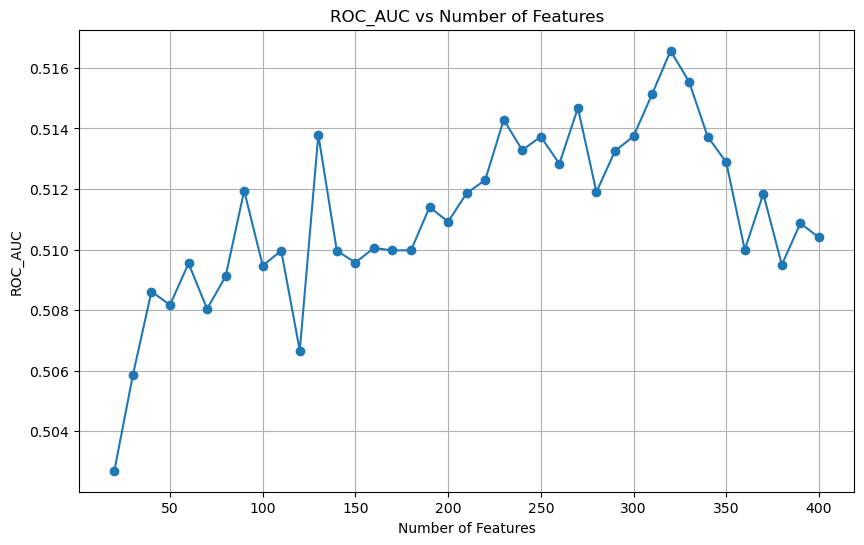

In [7]:
model = model_lgb = lgb.LGBMClassifier(random_state=42, verbose=-1)

scores = []
n_features = []

for n in tqdm(range(20, 401, 10)):
    rfe = RFE(model, n_features_to_select=n, step=30)
    
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe, y_train)
    
    y_pred = model.predict(X_test_rfe)
    
    accuracy = roc_auc_score(y_test, y_pred)
    
    scores.append(accuracy)
    n_features.append(n)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_features, scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('ROC_AUC')
plt.title('ROC_AUC vs Number of Features')
plt.grid(True)
plt.show()

### RFE TEST

In [8]:
model = model_lgb = lgb.LGBMClassifier(random_state=42)

rfe = RFE(estimator=model, n_features_to_select=20)
rfe.fit(X_train, y_train)
print("Обучен RFE")

selected_feature_indices = rfe.get_support(indices=True)

X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]

model.fit(X_train_selected, y_train)
print("Модель обучена")

predictions = model.predict(X_test_selected)

roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC_AUC: {roc_auc}')

KeyboardInterrupt: 

### PolyFeatures

In [99]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

def generate_poly_features(X, poly, batch_size=1000):
    num_samples = X.shape[0]
    poly_features = []
    for i in tqdm(range(0, num_samples, batch_size), desc="Generating Polynomial Features"):
        batch = X[i:i + batch_size]
        poly_batch = poly.fit_transform(batch)
        poly_features.append(poly_batch)
    return np.vstack(poly_features)

X_train_poly = generate_poly_features(X_train_selected, poly)
X_test_poly = generate_poly_features(X_test_selected, poly)

feature_names = poly.get_feature_names_out(pd.DataFrame(X_train_selected).columns.astype(str))

X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=feature_names)

print(f"Размер X_train_selected: {X_train_selected.shape}")
print(f"Размер X_train_poly_df: {X_train_poly_df.shape}")
print(f"Размер X_test_selected: {X_test_selected.shape}")
print(f"Размер X_test_poly_df: {X_test_poly_df.shape}")

model_lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model_lgbm.fit(X_train_poly_df, y_train)

y_pred_proba = model_lgbm.predict_proba(X_test_poly_df)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

Generating Polynomial Features: 100%|██████████| 4/4 [00:00<00:00, 281.85it/s]


Размер X_train_selected: (16000, 20)
Размер X_train_poly_df: (16000, 230)
Размер X_test_selected: (4000, 20)
Размер X_test_poly_df: (4000, 230)
ROC AUC: 0.9206784512839801


In [100]:
ffeature_importances = model_lgbm.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
max_auc = 0
max_i = 0

for i in range(1, 100):
    columns = np.array(feature_importance_df[feature_importance_df['importance'] > i]['feature'])
    model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    
    X_train_poly_df = X_train_poly_df[columns]
    X_test_poly_df = X_test_poly_df[columns]
    model.fit(X_train_poly_df, y_train)
    
    y_pred_proba = model.predict_proba(X_test_poly_df)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc}, i = {i}")

    if roc_auc < 0.9:
        break
        
    if roc_auc > max_auc:
        max_auc = roc_auc
        max_i = i
        

print(max_auc, max_i)

ROC AUC: 0.9206784512839801, i = 1
ROC AUC: 0.9187515671033661, i = 2
ROC AUC: 0.9214649412858607, i = 3
ROC AUC: 0.9215494995716584, i = 4
ROC AUC: 0.9209327791011095, i = 5
ROC AUC: 0.9186418698677363, i = 6
ROC AUC: 0.9209007840740508, i = 7
ROC AUC: 0.9201240884682087, i = 8
ROC AUC: 0.9229295299734637, i = 9
ROC AUC: 0.9221655670824715, i = 10
ROC AUC: 0.9227904495497189, i = 11
ROC AUC: 0.9217695470026536, i = 12
ROC AUC: 0.9217826061973716, i = 13
ROC AUC: 0.9223591696441631, i = 14
ROC AUC: 0.9215393786957521, i = 15
ROC AUC: 0.9215974921122463, i = 16
ROC AUC: 0.9222497988884013, i = 17
ROC AUC: 0.9198661693725319, i = 18
ROC AUC: 0.9201169059111138, i = 19
ROC AUC: 0.9182608678618442, i = 20
ROC AUC: 0.9219987358699513, i = 21
ROC AUC: 0.9205534094945569, i = 22
ROC AUC: 0.9200649956121105, i = 23
ROC AUC: 0.9194838614471679, i = 24
ROC AUC: 0.9188367783488999, i = 25
ROC AUC: 0.9162468135564888, i = 26
ROC AUC: 0.9066515702375728, i = 27
ROC AUC: 0.9066515702375728, i = 28
R

In [101]:
# Ура, выбили 0.92 - осталось сделать это все пайплайном и внести временную зависимость

# Закомментированный код

In [ ]:
# X_train_selected = pd.read_csv('rfe_train.csv')
# X_test_selected = pd.read_csv('rfe_test.csv')

In [ ]:
# X_train_selected.columns = np.arange(0, 26)
# X_test_selected.columns = np.arange(0, 26)

# X_train_selected = X_train_selected.drop(0, axis=1)
# X_test_selected = X_test_selected.drop(0, axis=1)

In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components=389)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# model = model_lgb = lgb.LGBMClassifier(random_state=42)

# rfe = RFE(estimator=model, n_features_to_select=25)
# rfe.fit(X_train, y_train)
# selected_feature_indices = rfe.get_support(indices=True)

# X_train_selected = X_train[:, selected_feature_indices]
# X_test_selected = X_test[:, selected_feature_indices]

In [ ]:
# rfe = RFE(estimator=model, n_features_to_select=25, step=10)
# rfe.fit(X_train, y_train)
# selected_feature_indices = rfe.get_support(indices=True)

# X_train_selected = X_train[:, selected_feature_indices]
# X_test_selected = X_test[:, selected_feature_indices]

In [ ]:
# model.fit(X_train_selected, y_train)

# y_pred = model.predict_proba(X_test_selected)[:, 1]

# roc_auc = roc_auc_score(y_val, y_pred)

# n_features_list.append(n_features_to_select)
# roc_auc_list.append(roc_auc)

# print(f"Количество признаков: {n_features_to_select}, ROC-AUC: {roc_auc}")

In [ ]:
#Количество признаков: 25, ROC-AUC: 0.8008241473752848 - оптимум